# ENVI Tutorial on Spatial Pancreas data

### Pre-requisites

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scenvi

2024-07-03 14:30:33.710547: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
#import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
#from fa2 import ForceAtlas2

In [4]:
!pip install squidpy

### Data

In [5]:
adata_sc = sc.read('../../../../spatial_pancreas_data/preprocessed_data/dissociated_nd_annotation_l0.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 21453 × 23146
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
     var: 'n_cells'
     uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
     obsm: 'X_pca', 'X_scVI', 'X_umap'
     layers: 'counts', 'soupX_counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [6]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['ND'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 61460 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [7]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    layer='counts',
)
adata_sc

AnnData object with n_obs × n_vars = 21453 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

Homogeneizing clustering to have same labels as in spatial 

In [8]:
adata_sc.obs['cell_type_coarse'].cat.categories

Index(['Alpha', 'Beta', 'Delta', 'Ductal', 'Ductal_Acinar_MUC1_AMY2A',
       'Immune', 'T-cells', 'Fibroblasts', 'Endothelial', 'Lymphatic',
       'Acinar_OLFM4+', 'Acinar'],
      dtype='object')

In [9]:
cluster2annotation = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Delta' : 'Endocrine',
    'Ductal' : 'Ductal',
    'Ductal_Acinar_MUC1_AMY2A' : 'Ductal',
    'Immune' : 'Immune',
    'T-cells' : 'Immune',
    'Fibroblasts' : 'Fibroblasts',
    'Endothelial' : 'Endothelial',
    'Lymphatic' : 'Endothelial',
    'Acinar_OLFM4+' : 'Acinar', 
    'Acinar' : 'Acinar'
}

adata_sc.obs['cell_type'] = adata_sc.obs['cell_type_coarse'].map(cluster2annotation).astype('category')

adata_sc.obs['cell_type'].cat.reorder_categories(['Acinar','Alpha','Beta','Ductal','Endocrine','Endothelial',
                                                         'Fibroblasts','Immune'])#,inplace=True)

AAACCCAGTGGTCTCG-1         Acinar
AAACCCATCCATCCGT-1         Acinar
AAACGAATCGAAATCC-1         Acinar
AAACGAATCGCCTAGG-1         Acinar
AAACGCTAGGCTAACG-1         Acinar
                         ...     
TTTGTTGGTGAGTAGC-1         Acinar
TTTGTTGGTGTATACC-1         Acinar
TTTGTTGGTGTCCACG-1         Acinar
TTTGTTGTCAACTGGT-1    Fibroblasts
TTTGTTGTCGTTAGAC-1         Acinar
Name: cell_type, Length: 21453, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial', 'Fibroblasts', 'Immune']

In [10]:
adata_sc.uns['cell_type_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

In [ ]:
sc.pp.subsample(adata_sc,fraction=0.5)
adata_sc

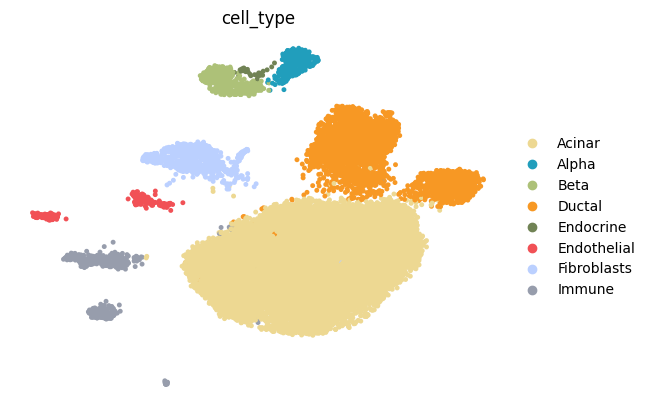

In [11]:
sc.pl.umap(adata_sc, color='cell_type', frameon=False,size=50,save='sc_ct.pdf')

Subset to a field of view to test the mapping problem 

In [12]:
adata_sp.obs.cell_type_coarse.cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

In [13]:
cluster2annotation = {
    'Acinar' : 'Acinar', 
    'Alpha' : 'Alpha', 
    'Beta' : 'Beta', 
    'Ductal' : 'Ductal', 
    'Endocrine' : 'Endocrine', 
    'Endothelial' : 'Endothelial',
    'Fibroblasts' : 'Fibroblasts', 
    'Immune' : 'Immune', 
    'Mast' : 'Immune'
}

adata_sp.obs['cell_type'] = adata_sp.obs['cell_type_coarse'].map(cluster2annotation).astype('category')

adata_sp.obs['cell_type'].cat.reorder_categories(['Acinar','Alpha','Beta','Ductal','Endocrine','Endothelial',
                                                         'Fibroblasts','Immune'])#,inplace=True)

1_12            Acinar
2_12            Acinar
3_12            Ductal
4_12            Ductal
5_12            Ductal
              ...     
4724_24    Fibroblasts
4725_24         Acinar
4726_24         Acinar
4727_24         Acinar
4728_24         Acinar
Name: cell_type, Length: 61460, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial', 'Fibroblasts', 'Immune']

In [14]:
adata_sp.uns['cell_type_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune\
    #'#582f0e'  #mast
]

In [15]:
adata_sp.obs.fov

1_12       12
2_12       12
3_12       12
4_12       12
5_12       12
           ..
4724_24    24
4725_24    24
4726_24    24
4727_24    24
4728_24    24
Name: fov, Length: 61460, dtype: category
Categories (13, object): ['12', '13', '14', '15', ..., '21', '22', '23', '24']

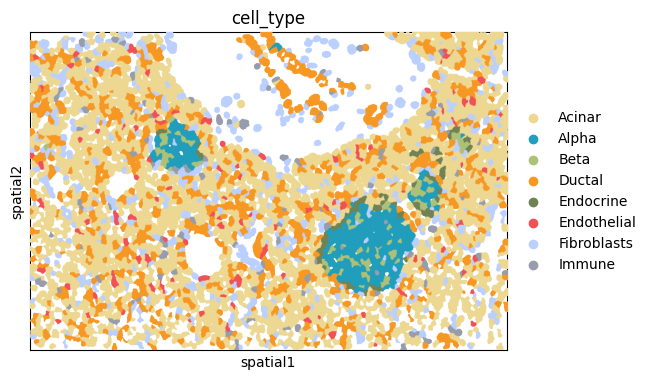

In [16]:
import squidpy as sq
sq.pl.spatial_segment(adata_sp,color=['cell_type'],library_id=['19'],
                      library_key='fov', seg_cell_id='cell_ID', img=False)#,save='ct_fvo_19.pdf')

In [17]:
adata_sp_fov_12 = adata_sp[np.isin(adata_sp.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [18]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)
sc.tl.leiden(adata_sp_fov_12)

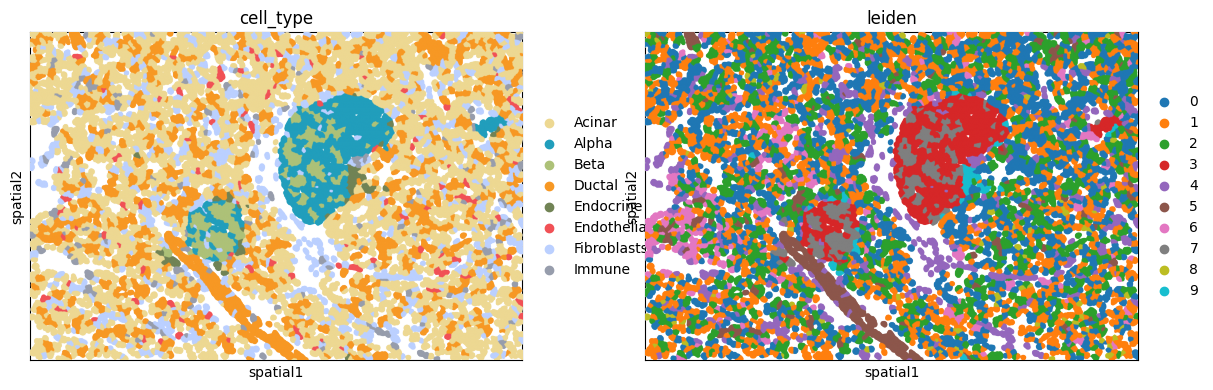

In [19]:
import squidpy as sq
sq.pl.spatial_segment(adata_sp_fov_12,color=['cell_type','leiden'],
                      library_key='fov', seg_cell_id='cell_ID', img=False)

### Running ENVI

ENVI requires un-logged counts and it doesn't work with adata.X sparse 

In [20]:
st_data = adata_sp_fov_12.copy()
st_data.X = st_data.layers['counts'].toarray()

sc_data = adata_sc.copy()
sc_data.X = adata_sc.layers['counts'].toarray()

print(sc_data.X.max())
print(st_data.X.max())

st_data, sc_data

8.0858965
177


(AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type', 'leiden'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_colors', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'c

In [21]:
# the gene names in the spatial data must be contained in the dissociated data 
st_data = st_data[:,np.isin(st_data.var_names, sc_data.var_names)].copy()
st_data

AnnData object with n_obs × n_vars = 5208 × 444
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type', 'leiden'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_colors', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'


In [22]:
#sc_data.obs['cell_type'] = sc_data.obs['cell_type_coarse']
st_data.obs['cell_type'] = st_data.obs['cell_type']

In [23]:
envi_model = scenvi.ENVI(spatial_data = st_data, sc_data = sc_data)

Computing Niche Covariance Matrices
Initializing VAE
Finished Initializing ENVI


In [24]:
envi_model.train()
envi_model.impute_genes()
envi_model.infer_niche_covet()
envi_model.infer_niche_celltype(cell_type_key='cell_type')

 spatial: -2.828e-01 sc: -1.514e-01 cov: -1.999e-03 kl: 5.190e-01: 100%|██████████| 16000/16000 [03:30<00:00, 76.01it/s] 


Finished imputing missing gene for spatial data! See 'imputation' in obsm of ENVI.spatial_data


In [25]:
st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']
st_data.obsm['cell_type_niche'] = envi_model.spatial_data.obsm['cell_type_niche']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.obsm['cell_type_niche'] = envi_model.sc_data.obsm['cell_type_niche']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

In [26]:
st_data.uns['COVET_genes']

array(['APOD', 'C11orf96', 'C1QA', 'C1QC', 'CASR', 'CCL2', 'CD163',
       'CD44', 'CD74', 'CHGA', 'COL1A1', 'COL27A1', 'COL3A1', 'COL4A2',
       'COL6A1', 'COL6A2', 'COL6A3', 'COL9A3', 'CPA3', 'CPB1', 'CUZD1',
       'CXCL2', 'CXCL3', 'CXCL8', 'DCN', 'G6PC2', 'GC', 'GCG', 'GSN',
       'HLA-DRB1', 'IAPP', 'IER3', 'IL7R', 'INS', 'KRT19', 'LCN2',
       'LEFTY1', 'LIF', 'LMNA', 'LYZ', 'MALAT1', 'MEG3', 'MGP', 'MRC1',
       'OLFM4', 'PECAM1', 'PRSS2', 'REG1A', 'SCG5', 'SELENOP', 'SERPINA1',
       'SERPINA3', 'SOD2', 'SPARCL1', 'SPINK1', 'SST', 'TAGLN', 'THBS1',
       'TIMP1', 'TNFRSF21', 'TPSB2', 'TTR', 'VWF', 'ZFP36'], dtype='<U8')

### ENVI imputation on Spatial Data 

In [27]:
markers = ['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [28]:
import anndata as ann# Create the anndata object
adata_imputed = ann.AnnData(st_data.obsm['imputation'])
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

In [29]:
adata_imputed.var_names

Index(['ACE', 'ACTA2', 'ACVRL1', 'ADGRA2', 'ADGRB3', 'ADGRD1', 'ADGRE2',
       'ADGRE5', 'ADGRF5', 'ADGRG3',
       ...
       'SGPP2', 'HIC1', 'MYL6', 'C19orf71', 'PCNX2', 'FGF22', 'SPRED3',
       'GXYLT2', 'AL121987.2', 'SYCP1'],
      dtype='object', length=5000)

In [30]:
import squidpy as sq

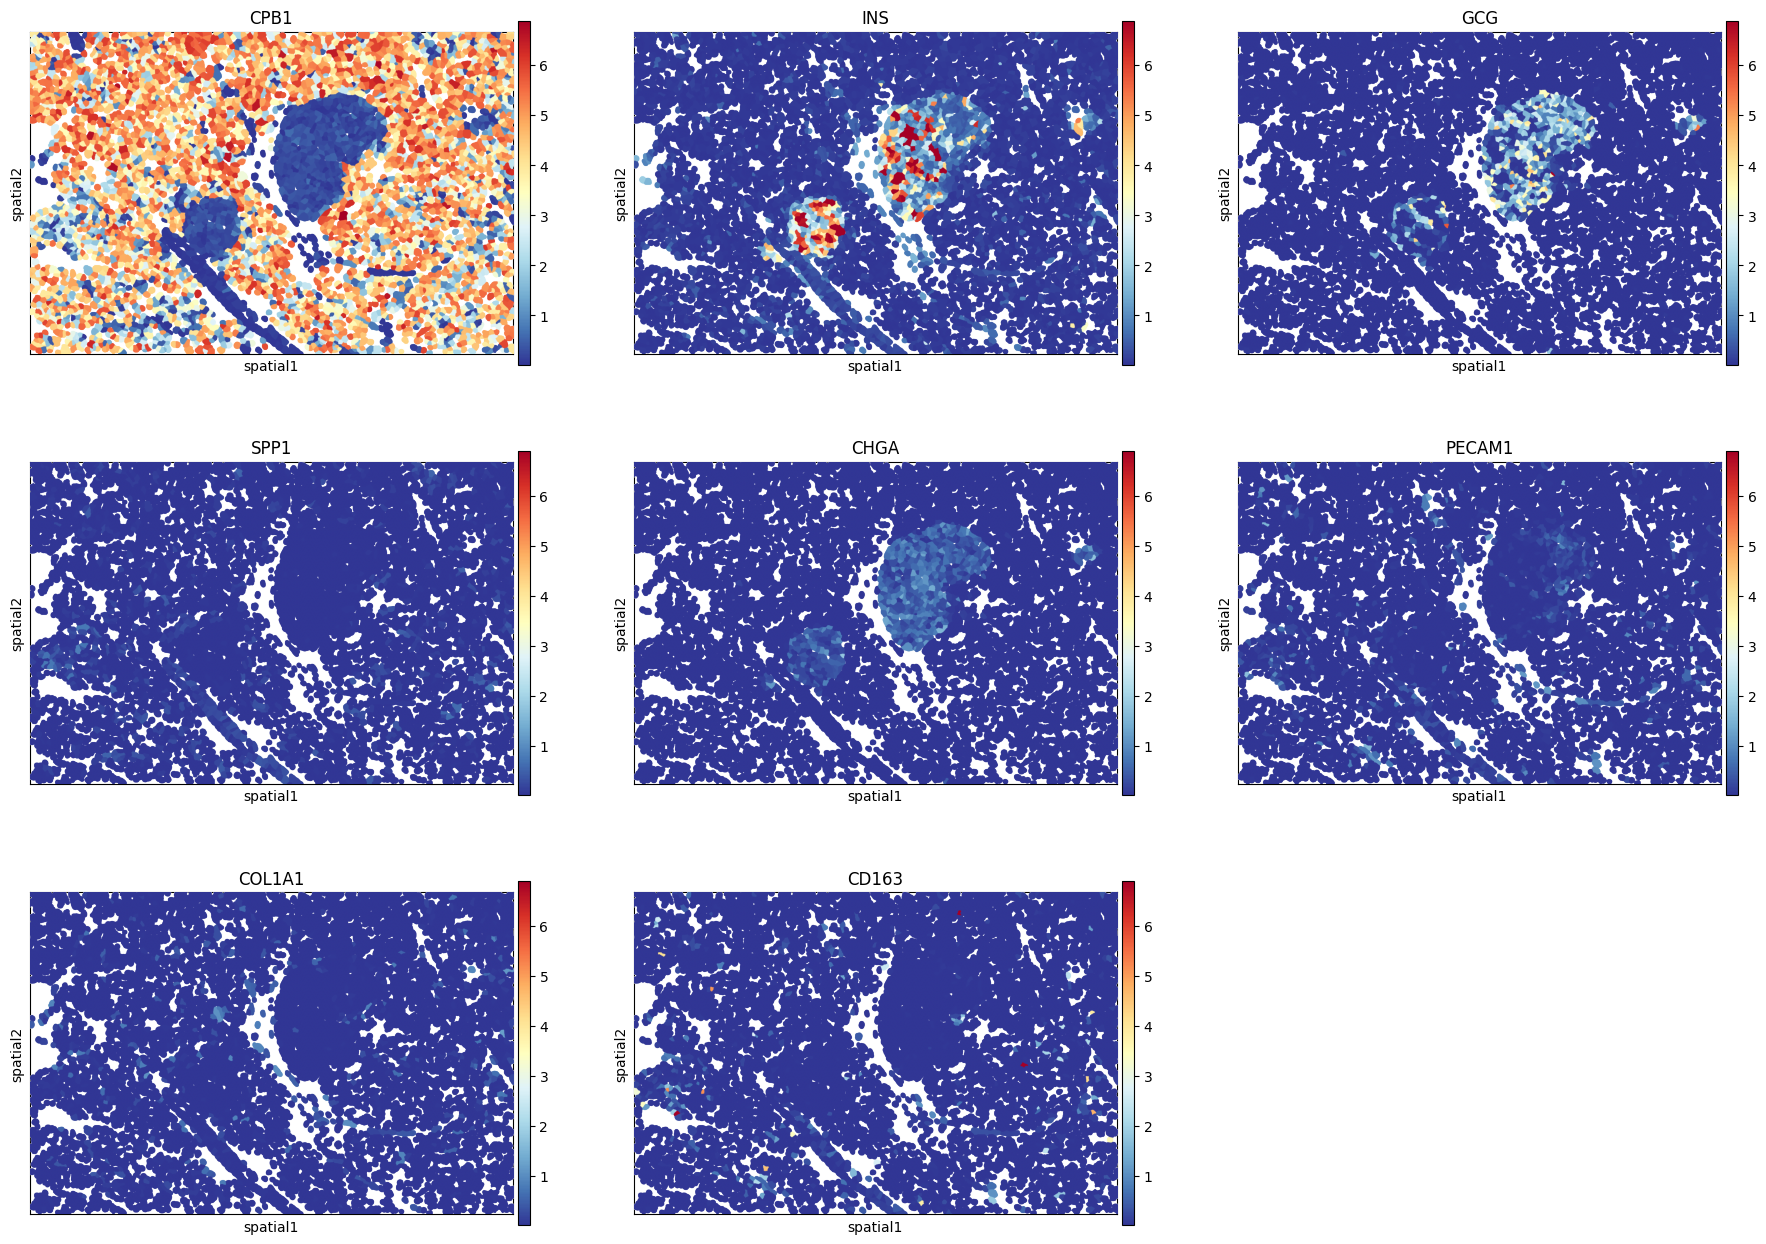

In [31]:
sq.pl.spatial_segment(adata_imputed,color=markers,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [32]:
from scipy.stats import pearsonr

correlations_hallmark_genes = []

for i in markers:
    gene = i
    obs_genes = adata_sp_fov_12[:,[gene]].X.copy().toarray().flatten()
    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
    correlation, p_value = pearsonr(obs_genes, imp_genes)
    row_data = {
        'gene' : gene,
        'Pearson_correlation' : correlation,
        'P_value' : p_value
    }
    correlations_hallmark_genes.append(row_data)
                
df = pd.DataFrame(correlations_hallmark_genes)

In [45]:
df

gene  Pearson_correlation        P_value
0    CPB1             0.818959   0.000000e+00
1     INS             0.766712   0.000000e+00
2     GCG             0.805184   0.000000e+00
3    SPP1             0.161521   8.874490e-32
4    CHGA             0.806358   0.000000e+00
5  PECAM1             0.152208   2.289213e-28
6  COL1A1             0.372884  1.695572e-171
7   CD163             0.259476   6.810757e-81

In [46]:
df.to_csv('../corr_envi.csv', sep='\t', index=False)

In [34]:
df['Pearson_correlation'].mean()

0.5179126328918626

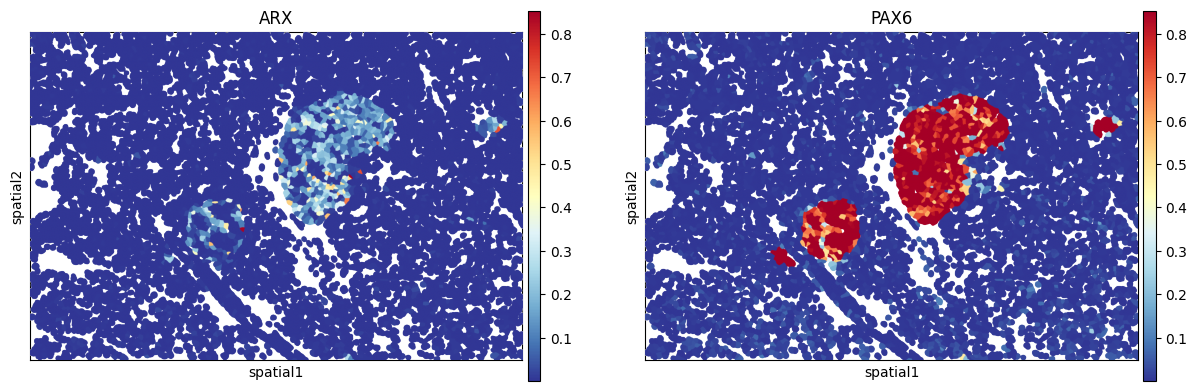

In [35]:
sq.pl.spatial_segment(adata_imputed,color=['ARX','PAX6'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [48]:
markers

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [36]:
adata_imputed.obs['cell_type'] = adata_sp_fov_12.obs['cell_type'] 
adata_imputed.uns['cell_type_colors'] = adata_sp_fov_12.uns['cell_type_colors']
#adata_imputed.layers['counts'] = adata_sp_fov_12.layers['counts']
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID', 'cell_type'
    uns: 'spatial', 'cell_type_colors'
    obsm: 'spatial'

In [49]:
adata_sp_fov_12,adata_imputed

(AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type', 'leiden'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_colors', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'c

In [68]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 12,            # Global font size
    'axes.titlesize': 16,       # Title font size
    'axes.labelsize': 14,       # Axis label font size
    'xtick.labelsize': 16,      # X-axis tick label font size
    'ytick.labelsize': 16,      # Y-axis tick label font size
    'legend.fontsize': 16,      # Legend font size
    'legend.title_fontsize': 16 # Legend title font size
})

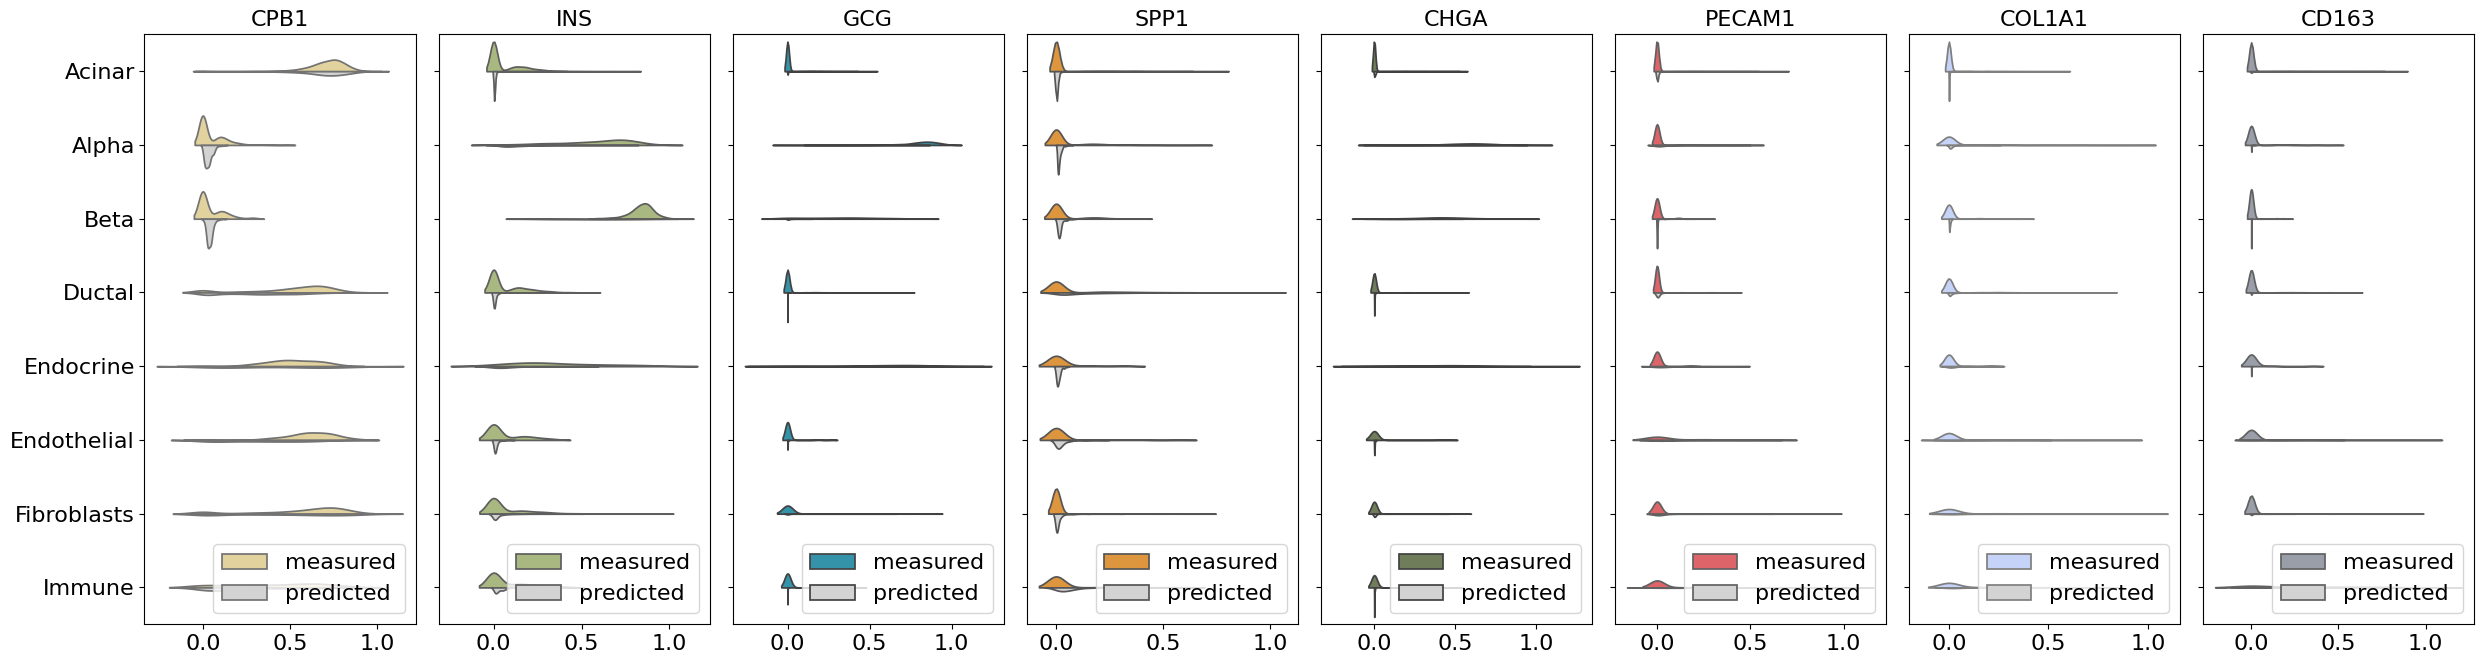

In [71]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1, len(markers), figsize=(25, 6.8), sharey=True)

color = ['#edd892', #acinar
    '#adc178', #beta
    '#219ebc', #alpha
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac'] #Immune

for i, marker in enumerate(markers):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_12, [marker, "cell_type"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
        inner=None,
        palette={"measured": color[i], "predicted": "lightgray"}
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
    ax[i].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [55]:
adata_sp_fov_12.write('/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/adata_sp_fov_12.h5ad')
adata_imputed.write('/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/imputed_envi.h5ad')

### Plot UMAPs of ENVI latent

In [37]:
cell_type_palette = {
    'Acinar'      : '#edd892', #acinar
    'Alpha'       : '#219ebc', #alpha
    'Beta'        : '#adc178', #beta
    'Ductal'      : '#f79824', #ductal
    'Endocrine'   : '#718355', #endocrine
    'Endothelial' :'#f15156', #endothelial
    'Fibroblasts' : '#bbd0ff', #Fibroblasts
    'Immune'      :'#979dac', #Immune
    #'Mast'        : '#582f0e'  #mast
}

In [40]:
sc_data.obsm['envi_latent'].shape

(21453, 512)

In [41]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.3,
    n_components = 2,
)

latent_umap = fit.fit_transform(np.concatenate([st_data.obsm['envi_latent'], sc_data.obsm['envi_latent']], axis = 0))

st_data.obsm['latent_umap'] = latent_umap[:st_data.shape[0]]
sc_data.obsm['latent_umap'] = latent_umap[st_data.shape[0]:]

In [42]:

lim_arr = np.concatenate([st_data.obsm['latent_umap'], sc_data.obsm['latent_umap']], axis = 0)


delta = 1
pre = 0.1
xmin = np.percentile(lim_arr[:, 0], pre) - delta
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta


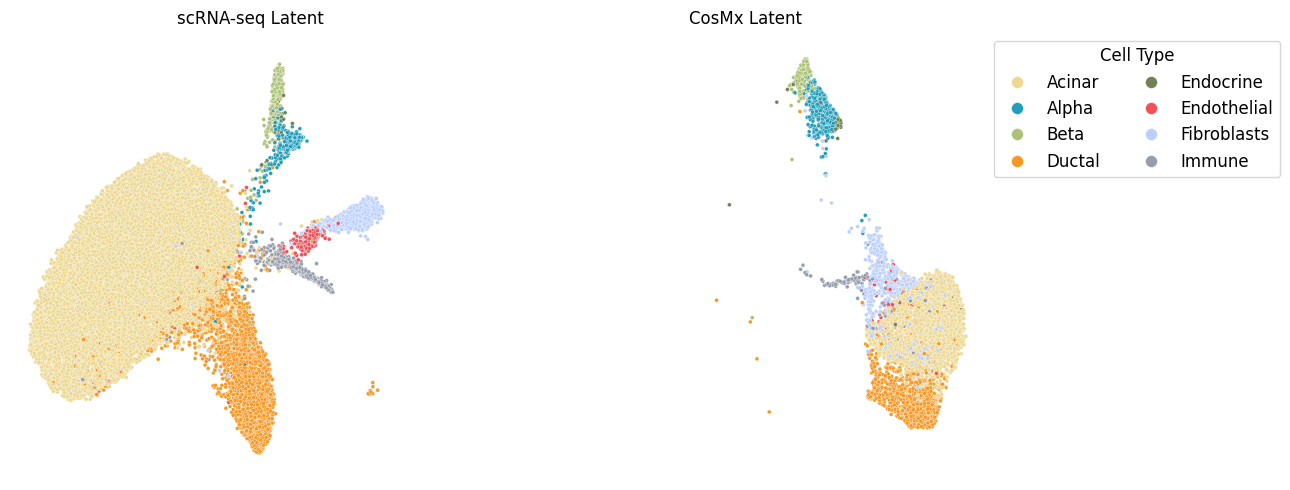

In [43]:
fig = plt.figure(figsize = (13,5))
plt.subplot(121)
sns.scatterplot(x = sc_data.obsm['latent_umap'][:, 0],
                y = sc_data.obsm['latent_umap'][:, 1], hue = sc_data.obs['cell_type'], s = 8, palette = cell_type_palette,
                legend = False)
plt.title("scRNA-seq Latent")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis('off')

plt.subplot(122)
sns.scatterplot(x = st_data.obsm['latent_umap'][:, 0],
                y = st_data.obsm['latent_umap'][:, 1],  hue = st_data.obs['cell_type'], s = 8, palette = cell_type_palette, legend = True)


legend = plt.legend(title = 'Cell Type', prop={'size': 12}, fontsize = '12',  markerscale = 3, ncol = 2, bbox_to_anchor = (1, 1))#, loc = 'lower left')
plt.setp(legend.get_title(),fontsize='12')
plt.title("CosMx Latent")
plt.axis('off')
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

In [44]:
st_data, sc_data

(AnnData object with n_obs × n_vars = 5208 × 444
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type', 'leiden'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_colors', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'COVET_genes'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'envi_latent', '

### ENVI COVET analysis

In [53]:
sc_data.obsm['cell_type_niche']

Acinar  Alpha  Beta  Ductal  Endocrine  Endothelial  \
AAACCCAGTGGTCTCG-1     7.0    0.0   0.0     0.4        0.0          0.0   
AAACCCATCCATCCGT-1     6.8    0.0   0.0     0.4        0.0          0.0   
AAACGAATCGAAATCC-1     6.6    0.0   0.0     0.6        0.0          0.0   
AAACGAATCGCCTAGG-1     6.2    0.0   0.0     0.8        0.0          0.0   
AAACGCTAGGCTAACG-1     7.2    0.0   0.0     0.6        0.0          0.0   
...                    ...    ...   ...     ...        ...          ...   
TTTGTTGGTGAGTAGC-1     6.2    0.0   0.0     0.8        0.0          0.0   
TTTGTTGGTGTATACC-1     7.0    0.0   0.0     0.4        0.0          0.0   
TTTGTTGGTGTCCACG-1     6.2    0.0   0.0     0.8        0.0          0.0   
TTTGTTGTCAACTGGT-1     0.0    8.0   0.0     0.0        0.0          0.0   
TTTGTTGTCGTTAGAC-1     6.8    0.0   0.0     0.4        0.0          0.0   

                    Fibroblasts  Immune  
AAACCCAGTGGTCTCG-1          0.6     0.0  
AAACCCATCCATCCGT-1          0.8     0.0  
AAACGAATCGAAATCC-1          0.8     0.0  
AAACGAATCGCCTAGG-1          1.0     0.0  
AAACGCTAGGCTAACG-1          0.2     0.0  
...                         ...     ...  
TTTGTTGGTGAGTAGC-1          1.0     0.0  
TTTGTTGGTGTATACC-1          0.6     0.0  
TTTGTTGGTGTCCACG-1          1.0     0.0  
TTTGTTGTCAACTGGT-1          0.0     0.0  
TTTGTTGTCGTTAGAC-1          0.8     0.0  

[21453 rows x 8 columns]

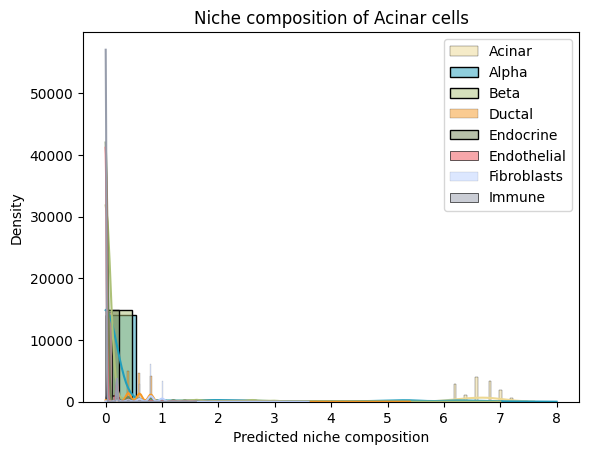

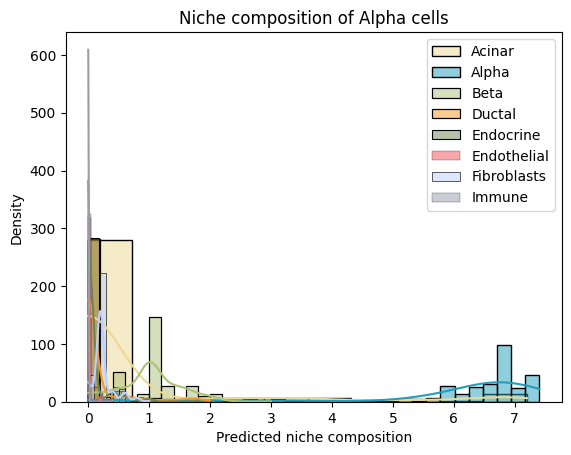

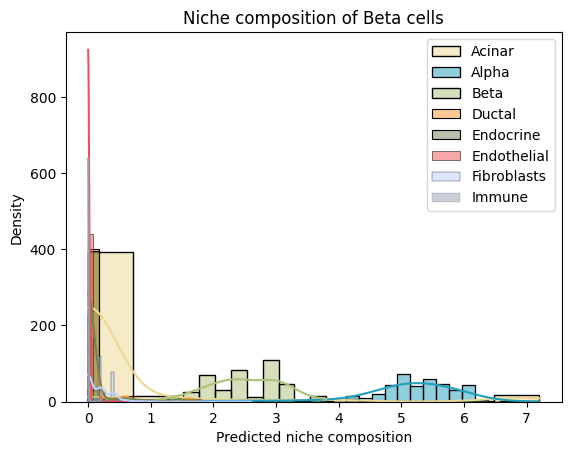

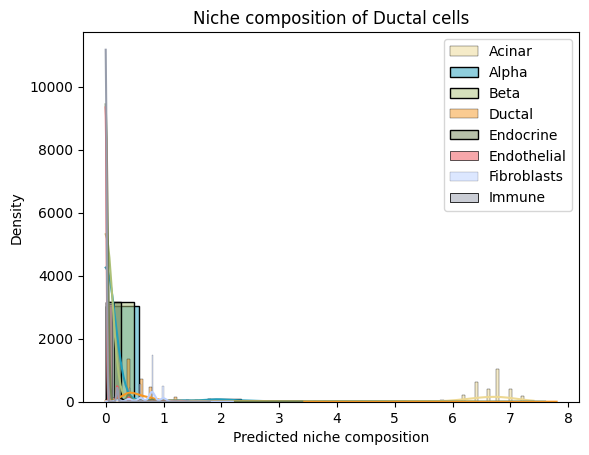

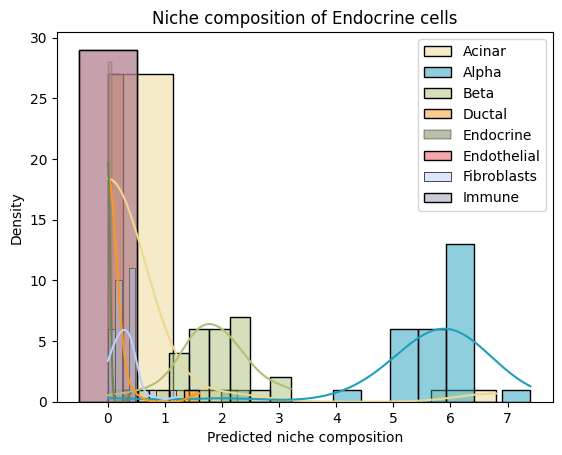

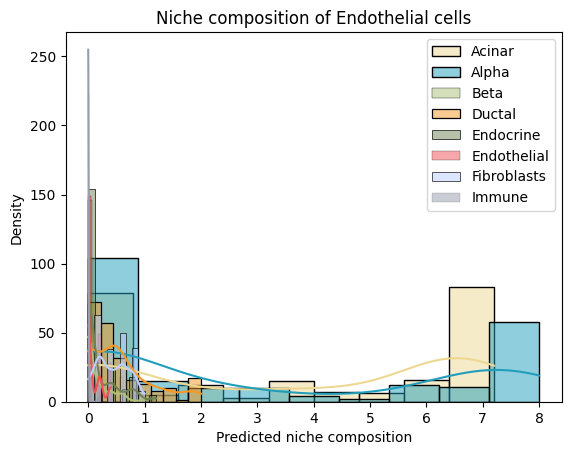

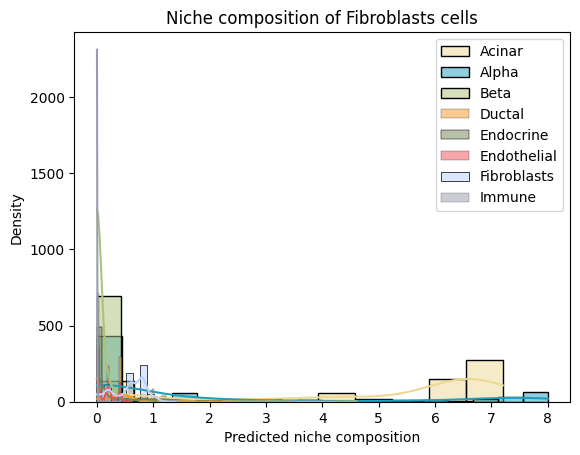

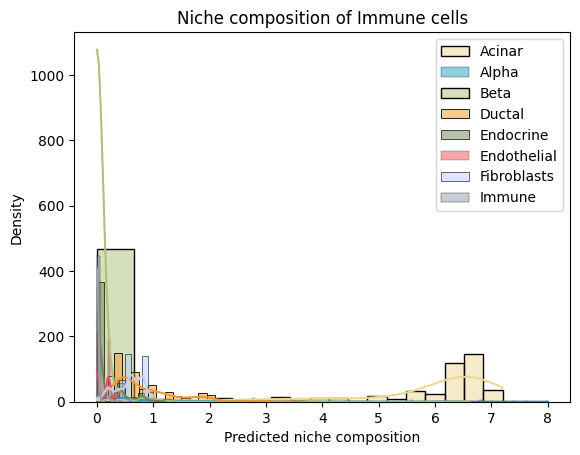

In [54]:
#plt.figure(figsize=(8, 6))

for i in sc_data.obs['cell_type'].cat.categories:
    sc_data_ct = sc_data[sc_data.obs['cell_type'] == i]
    
    for col in sc_data_ct.obsm['cell_type_niche'].columns:
        sns.histplot(sc_data_ct.obsm['cell_type_niche'][col], kde=True, color=cell_type_palette[col], label=col)
        #sns.hist(sc_data_ct.obsm['cell_type_niche'], kde=True, color=cell_type_palette, label=col)

    plt.xlabel('Predicted niche composition')
    plt.ylabel('Density')
    plt.title('Niche composition of '+i+' cells')
    plt.legend()
    plt.show()

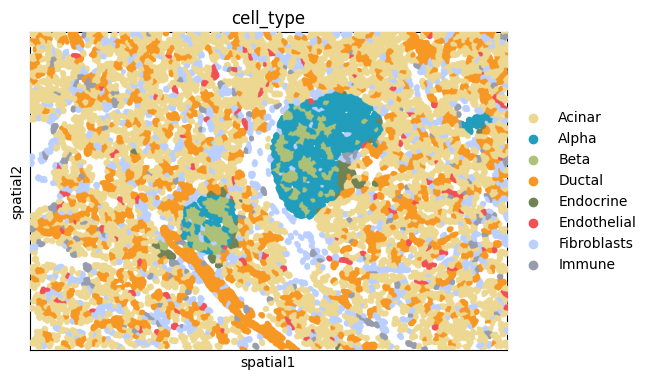

In [79]:
import squidpy as sq
sq.pl.spatial_segment(adata_sp,color=['cell_type'],library_id=['12'],
                      library_key='fov', seg_cell_id='cell_ID', img=False, save='cell_type.pdf')

In [96]:
marker_genes = {
    'Beta' : ['INS','IAPP','NKX6-1','PDX1','MAFA','NKX2-2','FOXA1','FOXA2','GCK'],
    'Alpha' : ['GCG','PAPPA2','IRX2','SLC7A2','TTR','PCSK2','ARX'],
    'Ductal' : ['SOX9','KRT19','MUC1','CA2','SPP1'],
    'Acinar' : ['CPB1','PRSS1','CTRB1','PNLIP','AMY2A','EGF','SPINK1'],
    'Fibroblasts' : ['COL3A1','COL1A1','MGP'],
    'Endothelial' : ['PECAM1','VWF','ENG'],
    'Immune' : ['CD163','ITGB2','C1QB'], # T reg cells
}

In [97]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata_sp.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [98]:
marker_genes_in_data

{'Beta': ['INS', 'IAPP'],
 'Alpha': ['GCG', 'TTR'],
 'Ductal': ['SOX9', 'KRT19', 'SPP1'],
 'Acinar': ['CPB1', 'EGF', 'SPINK1'],
 'Fibroblasts': ['COL3A1', 'COL1A1', 'MGP'],
 'Endothelial': ['PECAM1', 'VWF', 'ENG'],
 'Immune': ['CD163', 'ITGB2', 'C1QB']}

categories: Acinar, Alpha, Beta, etc.
var_group_labels: Beta, Alpha, Ductal, etc.


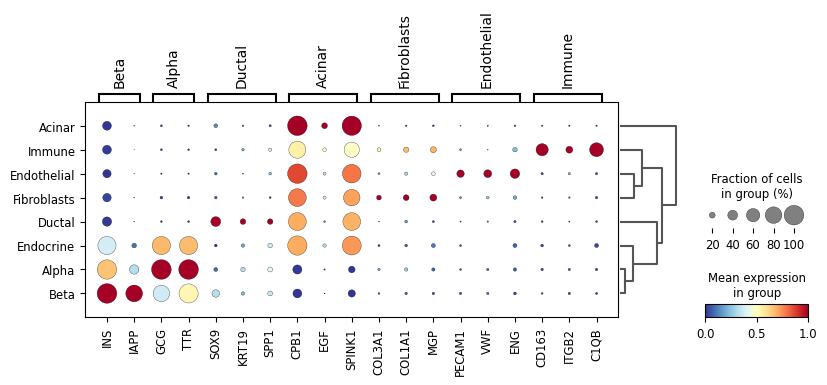

In [100]:
sc.pl.dotplot(
    adata_sp_fov_12,
    groupby='cell_type',
    var_names=marker_genes_in_data,
    standard_scale='var',  # standard scale: normalize each gene to range from 0 to 1
    color_map='RdYlBu_r',
    dendrogram=True,
    save='markers.pdf'
)

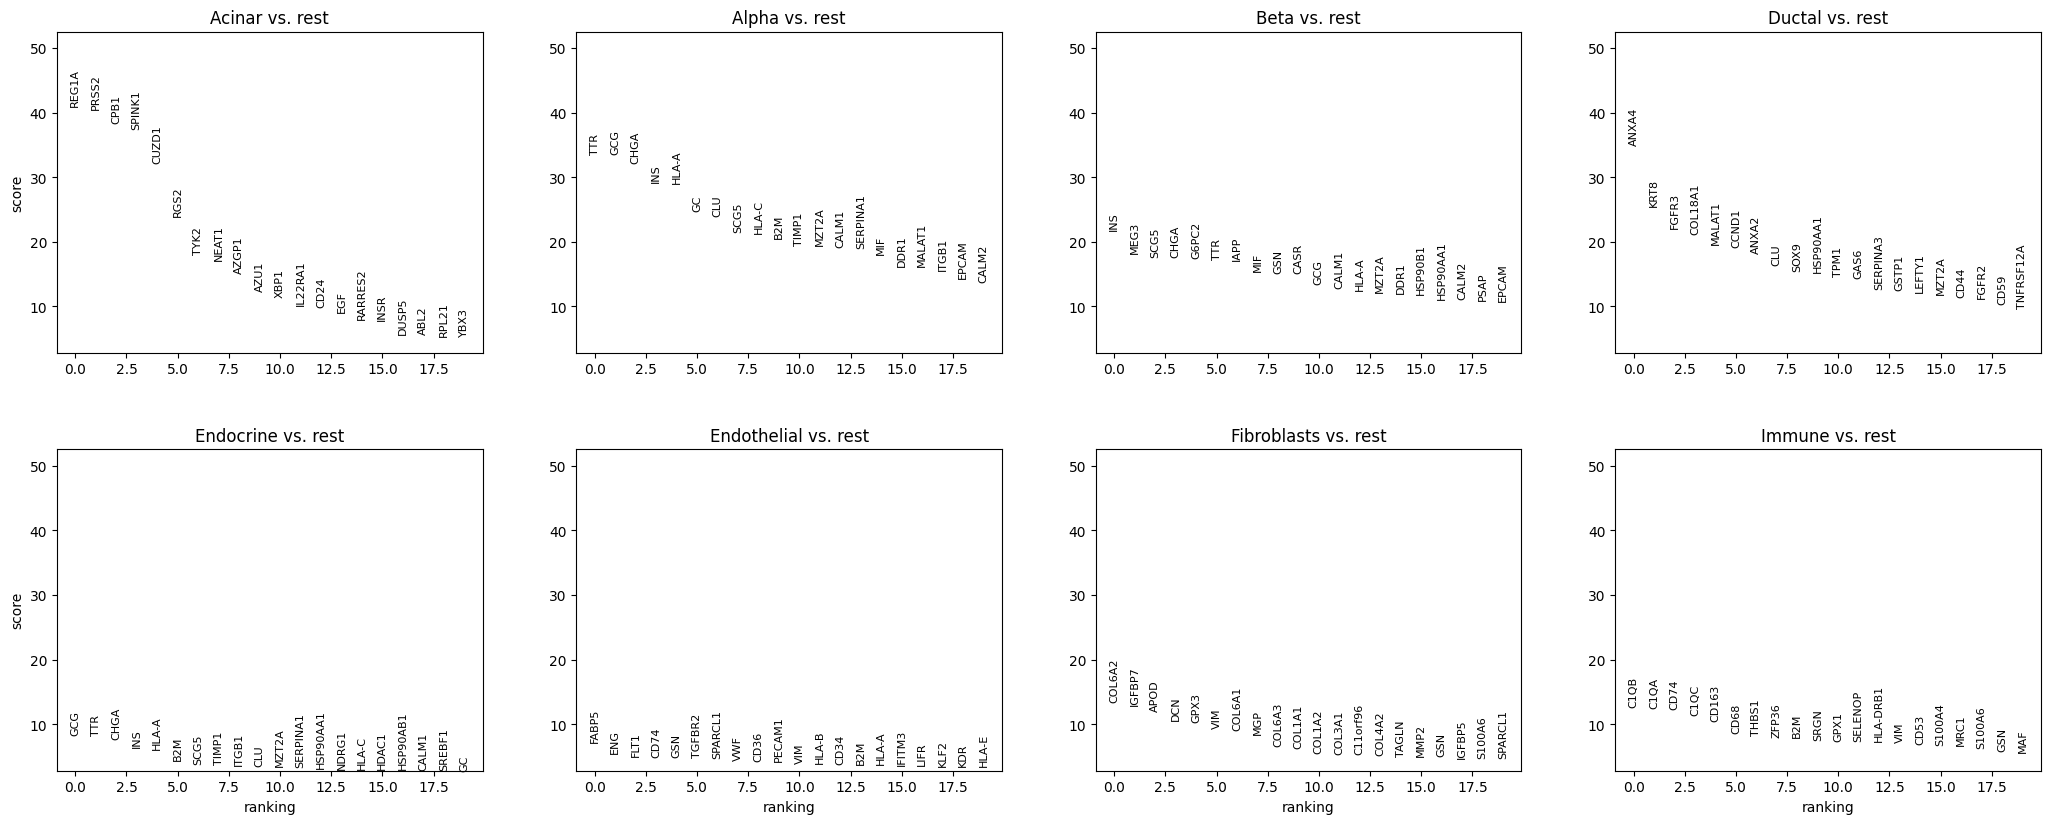

In [90]:
sc.tl.rank_genes_groups(adata_sp_fov_12, 'cell_type', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups(adata_sp_fov_12)

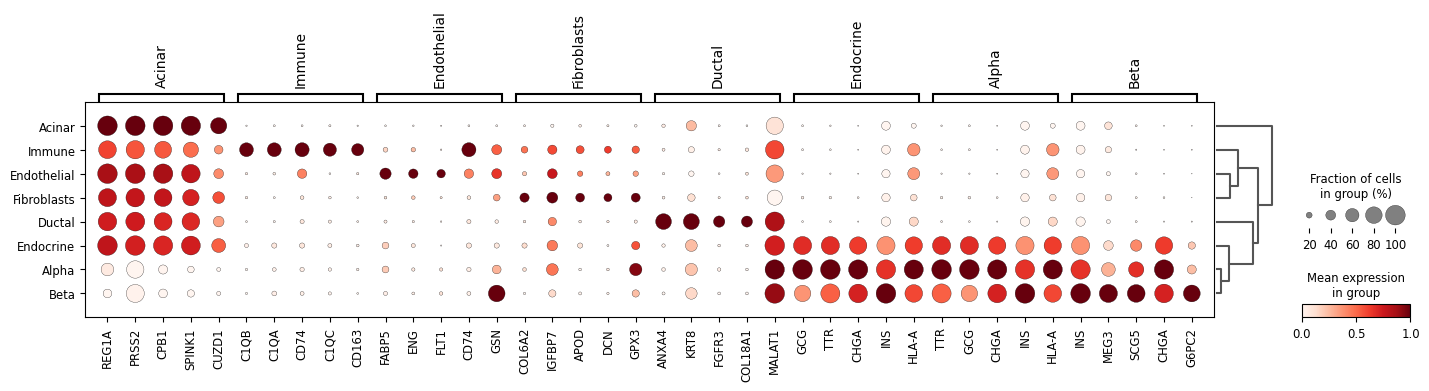

In [91]:
sc.pl.rank_genes_groups_dotplot(
    adata_sp_fov_12, groupby="cell_type", standard_scale="var", n_genes=5
)

In [107]:
markers = ['INS', 'GCG', 'SOX9', 'CPB1', 'COL1A1', 'PECAM1', 'CD163']

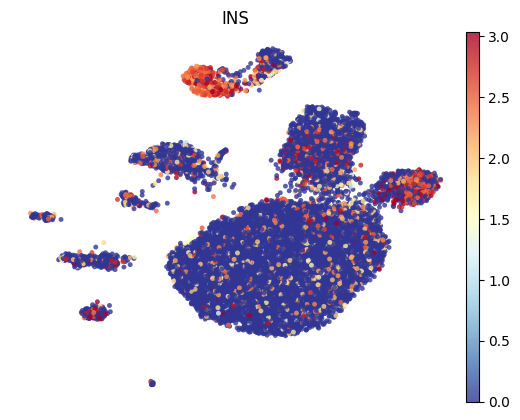

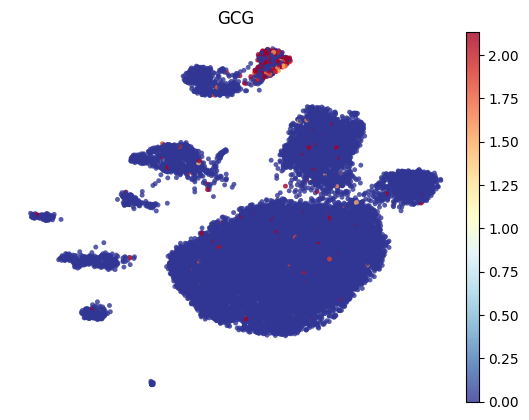

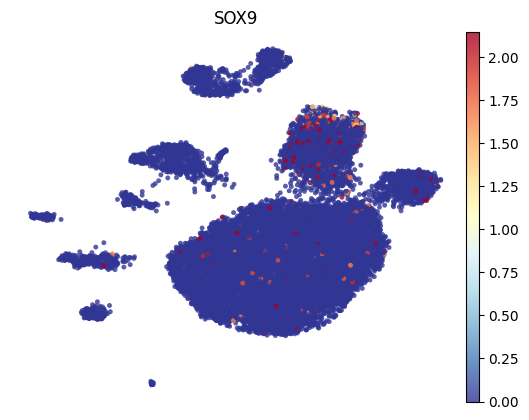

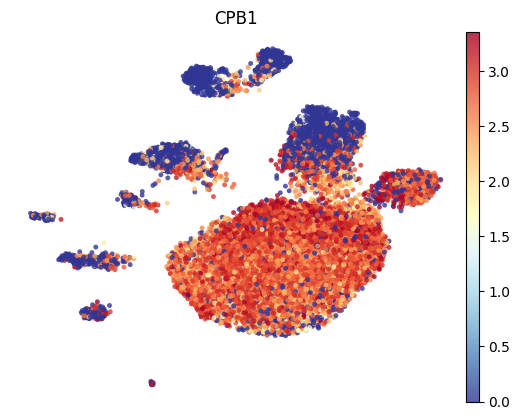

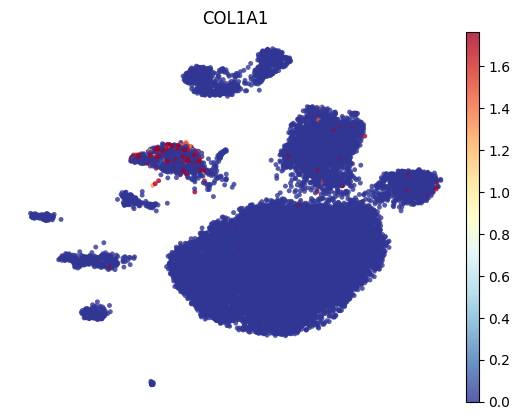

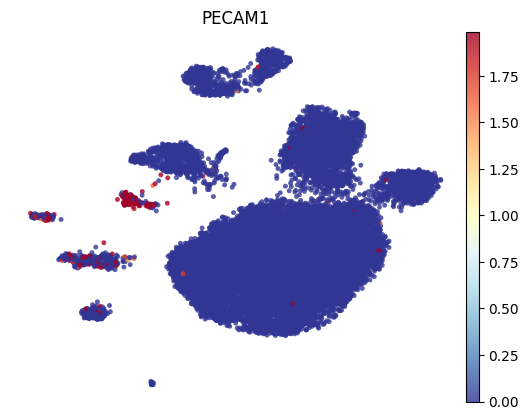

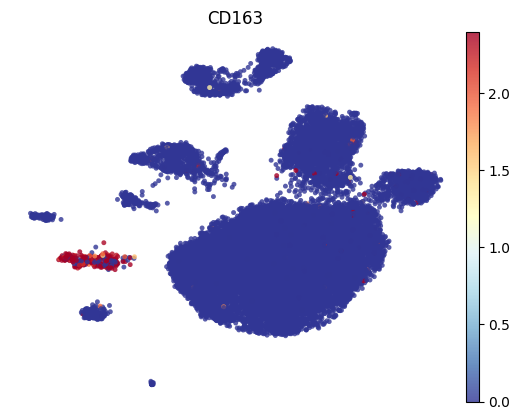

In [108]:
for i in markers:
    sc.pl.umap(adata_sc,
               color=i,
               vmin=0,
               vmax='p99',  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
               sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
               frameon=False,
               cmap='RdYlBu_r',  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               alpha=0.8,
               size=50,
               save=i+'_sc.pdf')

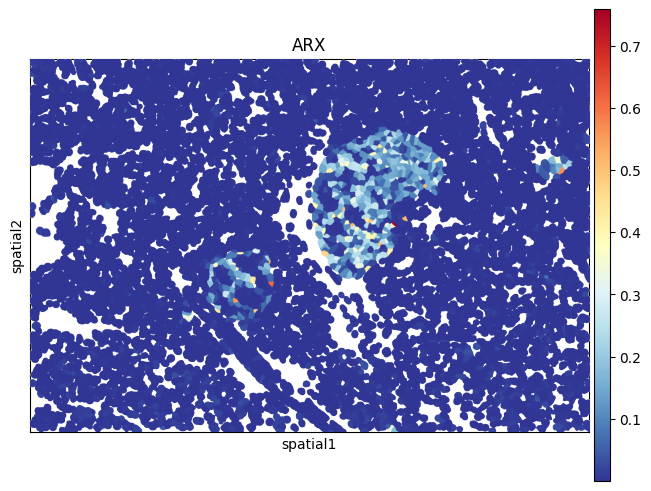

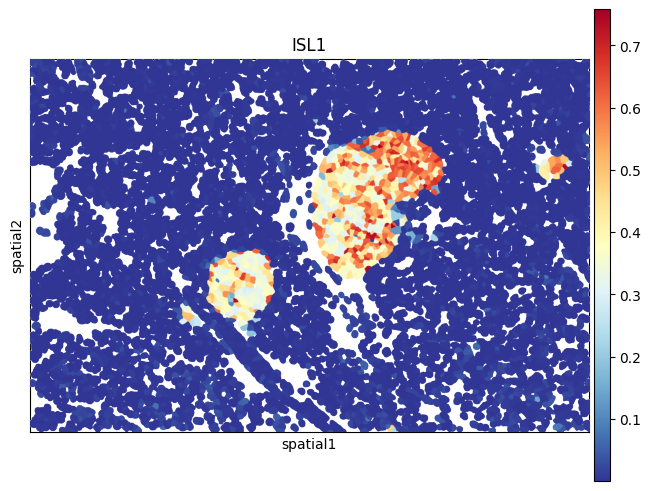

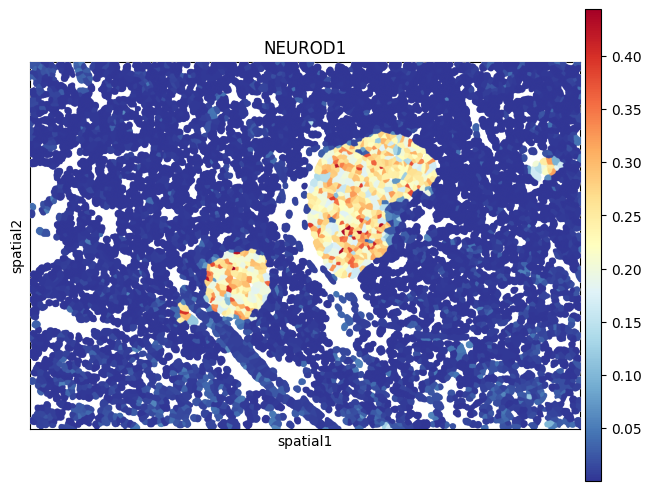

In [117]:
markers = ['ARX','ISL1','NEUROD1']
for i in markers:
    sq.pl.spatial_segment(adata_imputed,color=i,library_id=['12'],library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False,save=i+'_sp_envi.pdf')